In [1]:
import tensorflow as tf

# Create a new graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    W1 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[784, 16], # Shape
        stddev=(2/784)**0.5, # Calibrating variance
        seed=0
    ))
    b1 = tf.Variable(initial_value=tf.zeros(shape=[16]))

    # Output layer
    W2 = tf.Variable(initial_value=tf.truncated_normal(
        shape=[16, 10], # Shape
        stddev=1/16**0.5, # Calibrating variance
        seed=0
    ))
    b2 = tf.Variable(initial_value=tf.zeros(shape=[10]))

    # Compute logits
    hidden = tf.nn.relu( # ReLU
        tf.add(tf.matmul(X, W1), b1))
    logits = tf.add(tf.matmul(hidden, W2), b2)


In [2]:
# Redefine the graph
graph = tf.Graph()

with graph.as_default():
    # Create placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 784])
    y = tf.placeholder(dtype=tf.int32, shape=[None])

    # Hidden layer with 16 units
    hidden = tf.layers.dense(
        X, 16, activation=tf.nn.relu, # ReLU
        kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='hidden'
    )

    # Output layer
    logits = tf.layers.dense(
        hidden, 10, activation=None, # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0),
        bias_initializer=tf.zeros_initializer(),
        name='output'
    )

In [3]:
with graph.as_default():
    # Get variables in the graph
    for v in tf.trainable_variables():
        print(v)


<tf.Variable 'hidden/kernel:0' shape=(784, 16) dtype=float32_ref>
<tf.Variable 'hidden/bias:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'output/kernel:0' shape=(16, 10) dtype=float32_ref>
<tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>


In [4]:
with graph.as_default():
    # Get weights/biases of the hidden layer
    with tf.variable_scope('hidden', reuse=True):
        W1 = tf.get_variable('kernel')
        b1 = tf.get_variable('bias')

    # Get weights/biases of the output layer
    with tf.variable_scope('output', reuse=True):
        W2 = tf.get_variable('kernel')
        b2 = tf.get_variable('bias')

In [5]:
with graph.as_default():
    # Loss fuction: mean cross-entropy
    mean_ce = tf.reduce_mean(
        tf.nn.sparse_softmax_cross_entropy_with_logits(
            labels=y, logits=logits))

    # Gradient descent
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.GradientDescentOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load data
with np.load('mnist-20k.npz', allow_pickle=False) as npz_file:
    # Load items into a dictionary
    mnist = dict(npz_file.items())

# Create train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(
    # Convert uint8 pixel values to float
    mnist['data'].astype(np.float32),
    mnist['labels'],
    test_size=500, random_state=0)

# Rescale train and validation data
scaler = StandardScaler()
X_train_rescaled = scaler.fit_transform(X_train)
X_valid_rescaled = scaler.transform(X_valid)

In [7]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

In [9]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())

    # Set seed
    np.random.seed(0)

    # Train several epochs
    for epoch in range(50):
        # Accuracy values (train) after each batch
        batch_acc = []

        # Get batches of data
        for X_batch, y_batch in get_batches(X_train_rescaled, y_train, 64):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={
                X: X_batch,
                y: y_batch,
                lr: 0.01 # Learning rate
            })

            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={
            X: X_valid_rescaled,
            y: y_valid
        })
        valid_acc_values.append(valid_acc)

        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(
            epoch+1, valid_acc, np.mean(batch_acc)
        ))

    # Weights of the hidden and output layers
    weights_hidden = W1.eval()
    weights_output = W2.eval()


Epoch 1 - valid: 0.796 train: 0.631 (mean)
Epoch 2 - valid: 0.888 train: 0.849 (mean)
Epoch 3 - valid: 0.900 train: 0.881 (mean)
Epoch 4 - valid: 0.916 train: 0.897 (mean)
Epoch 5 - valid: 0.918 train: 0.906 (mean)
Epoch 6 - valid: 0.922 train: 0.914 (mean)
Epoch 7 - valid: 0.920 train: 0.919 (mean)
Epoch 8 - valid: 0.922 train: 0.923 (mean)
Epoch 9 - valid: 0.934 train: 0.926 (mean)
Epoch 10 - valid: 0.932 train: 0.929 (mean)
Epoch 11 - valid: 0.930 train: 0.932 (mean)
Epoch 12 - valid: 0.938 train: 0.934 (mean)
Epoch 13 - valid: 0.940 train: 0.936 (mean)
Epoch 14 - valid: 0.942 train: 0.939 (mean)
Epoch 15 - valid: 0.944 train: 0.942 (mean)
Epoch 16 - valid: 0.942 train: 0.943 (mean)
Epoch 17 - valid: 0.944 train: 0.944 (mean)
Epoch 18 - valid: 0.944 train: 0.947 (mean)
Epoch 19 - valid: 0.942 train: 0.947 (mean)
Epoch 20 - valid: 0.944 train: 0.949 (mean)
Epoch 21 - valid: 0.946 train: 0.950 (mean)
Epoch 22 - valid: 0.948 train: 0.951 (mean)
Epoch 23 - valid: 0.946 train: 0.952 (mea

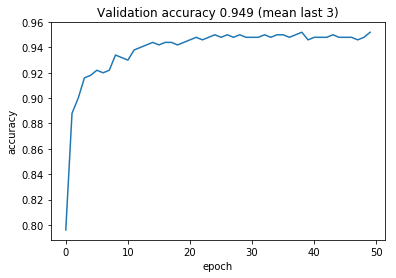

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy {:.3f} (mean last 3)'.format(
    np.mean(valid_acc_values[-3:]) # last three values
))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

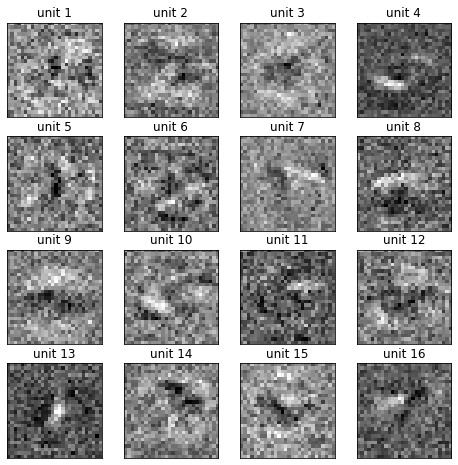

In [11]:
# Create figure with 16 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

# Plot the weights of the 16 hidden units
for i, axis in enumerate(axes.flatten()):
    # Get weights of i-th hidden unit
    weights = weights_hidden[:, i]

    # Reshape into 28 by 28 array
    weights = weights.reshape(28, 28)

    # Plot weights
    axis.set_title('unit {}'.format(i+1))
    axis.imshow(weights, cmap=plt.cm.gray_r) # Grayscale
    axis.get_xaxis().set_visible(False) # Disable x-axis
    axis.get_yaxis().set_visible(False) # Disable y-axis

plt.show()

In [16]:
import pandas as pd

# Output layer weights
pd.DataFrame(
    weights_output,
    index=['unit {}'.format(i+1) for i in range(16)],
    columns=['digit {}'.format(i) for i in range(10)],
)

,digit 0,digit 1,digit 2,digit 3,digit 4,digit 5,digit 6,digit 7,digit 8,digit 9
unit 1,-0.150635,0.284280,0.172178,0.446644,-0.714059,-0.183545,0.480236,0.116319,0.348585,-0.560221
unit 2,-0.533605,-0.624726,0.205316,-0.055993,-0.039835,-0.083887,-0.584757,1.024168,-0.344788,-0.045761
unit 3,0.074746,0.798945,-0.130343,-0.050163,0.641502,0.478911,-0.723179,-0.508814,-0.525445,0.610830
unit 4,-0.272620,0.319810,-0.086212,0.961566,0.315073,1.009380,-0.286824,-0.434256,-0.607773,0.439674
unit 5,-0.390938,0.912120,-0.415977,-0.429397,-0.021728,-0.192572,0.417320,0.325786,0.743209,0.001953
unit 6,-0.134027,-0.484235,0.186193,0.347218,-0.065945,-0.113834,-0.330623,-0.504097,0.871069,-0.370395
unit 7,-0.162861,-0.269230,-0.383844,-0.803909,-0.550477,0.650953,0.613397,-0.133613,0.656206,-0.386432
unit 8,-0.093129,0.015052,1.257021,-0.055705,-0.113250,0.205444,0.349810,-0.395492,-0.334742,-0.443195
unit 9,0.059370,-0.596976,0.650836,-0.048121,0.510583,-0.239879,0.634748,-0.066755,-0.398763,-0.894171
unit 10,-0.225325,-0.145420,-0.133197,0.659459,-0.405504,0.560460,-0.709342,-0.281560,0.334558,0.198609


In [12]:
weights_output

array([[-0.15063496,  0.28428015,  0.17217791,  0.44664443, -0.71405923,
        -0.18354547,  0.48023623,  0.11631861,  0.34858534, -0.5602208 ],
       [-0.5336049 , -0.6247259 ,  0.20531614, -0.05599257, -0.03983539,
        -0.08388672, -0.58475655,  1.0241681 , -0.34478796, -0.04576077],
       [ 0.07474565,  0.7989454 , -0.130343  , -0.05016294,  0.6415021 ,
         0.4789111 , -0.72317946, -0.50881374, -0.5254447 ,  0.61083   ],
       [-0.27261952,  0.3198101 , -0.08621242,  0.9615659 ,  0.3150732 ,
         1.0093799 , -0.28682435, -0.43425587, -0.6077725 ,  0.43967423],
       [-0.39093766,  0.9121201 , -0.4159772 , -0.42939734, -0.02172758,
        -0.19257152,  0.41731977,  0.32578632,  0.74320936,  0.00195343],
       [-0.13402705, -0.48423478,  0.186193  ,  0.3472184 , -0.06594466,
        -0.11383424, -0.3306233 , -0.50409734,  0.8710694 , -0.370395  ],
       [-0.16286148, -0.26923025, -0.38384378, -0.80390936, -0.55047697,
         0.6509528 ,  0.6133974 , -0.13361296